In [1]:
import numpy as np 
import matplotlib.pylab as plt 
import torch 
from anno.utils import AnnoDescription
import matplotlib.image as mpimg
from copy import deepcopy

/home/z.sun/miniconda3/envs/graph-wsi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
patches_test_path = "patches_test"
idx = 2
npz_file = f'{patches_test_path}/step_{idx}.npz'
data = np.load(npz_file)

# 提取数据
features = torch.from_numpy(data["features"]).float()  # 转换为 float32 张量
y_true = torch.from_numpy(data["y_true"]).long()       # 转换为 int64 张量
coords = torch.from_numpy(data["coords"]).float() 
img_path = data["img_path"]

In [3]:
anno_dsc = AnnoDescription.with_known_colors(
        {
            "AT": (245, 119, 34),  # AT (orange)
            "BG": (153, 255, 255),  # BG (cyan)
            "LP": (64, 170, 72),  # LP (green)
            "MM": (255, 0, 0),  # MM (red)
            "TUM": (33, 67, 156),  # TUM (blue)
        }
    )

In [4]:
y_true

tensor([1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 4, 4, 4, 4,
        0, 0, 0, 0, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4, 3, 3, 3, 3, 4, 4, 4, 4,
        0, 0, 0, 0, 3, 3, 3, 3, 1, 1, 1, 1, 4, 4, 4, 4])

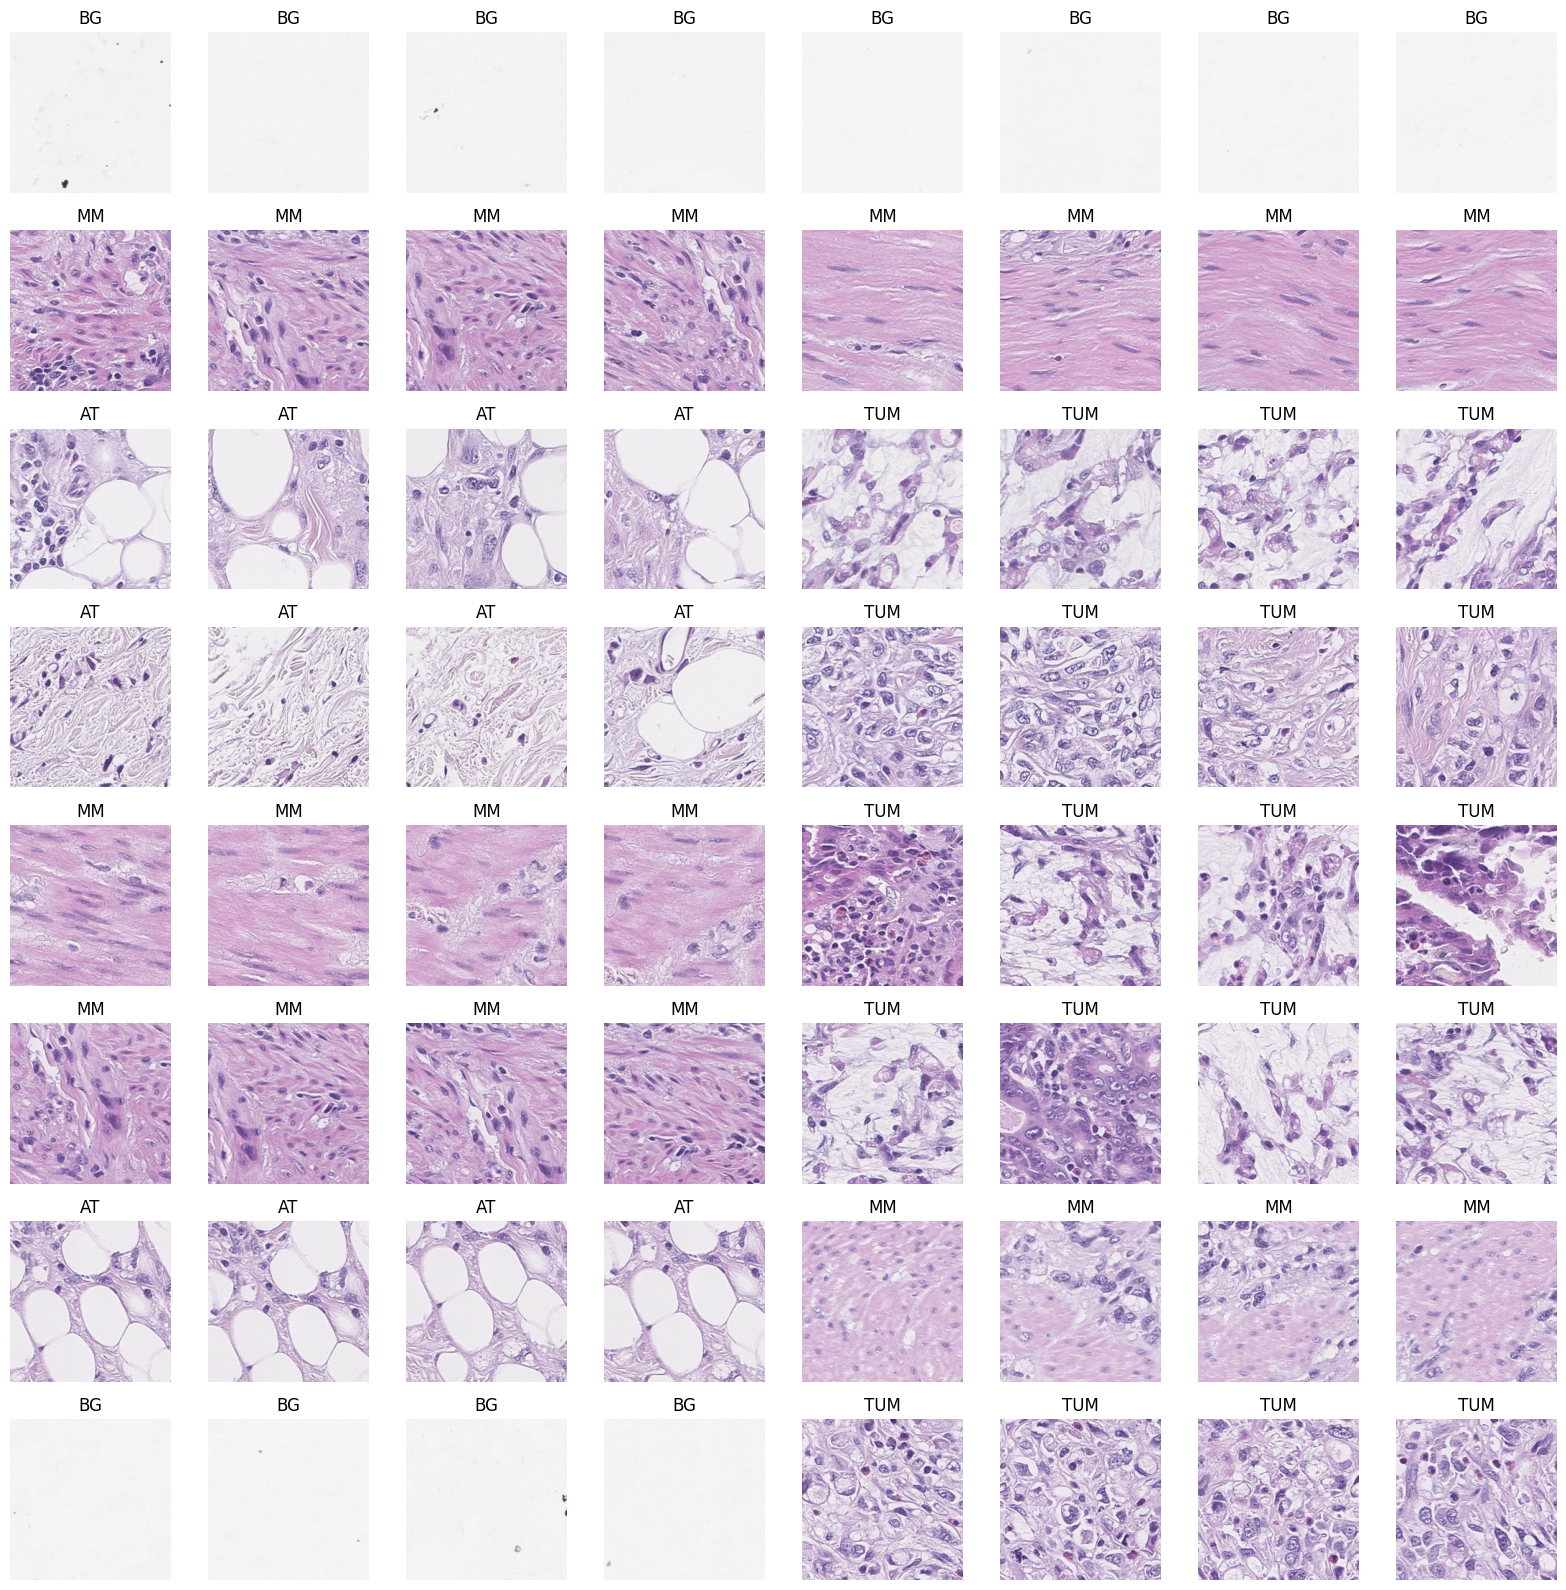

In [5]:
fig, axes = plt.subplots(8, 8, figsize=(16, 16))

# 遍历 idx 从 0 到 63
for i in range(8):
    for j in range(8):
        idx = i * 8 + j
        if len(features) > idx:
            # 选择对应的特征图
            feature = features[idx]  # 形状为 (3, 224, 224)

            # 将形状从 (channels, height, width) 转换为 (height, width, channels)
            feature = feature.permute(1, 2, 0)  # 转换为 (224, 224, 3)

            # 将张量转换为 numpy 数组
            feature_np = feature.numpy()

            # 在对应的子图中显示图像
            axes[i, j].imshow(feature_np)
            axes[i, j].set_title(f"{anno_dsc.anno_classes[y_true[idx]].label}")
            axes[i, j].axis('off')  # 关闭坐标轴

# 调整子图布局
plt.tight_layout()
plt.show()

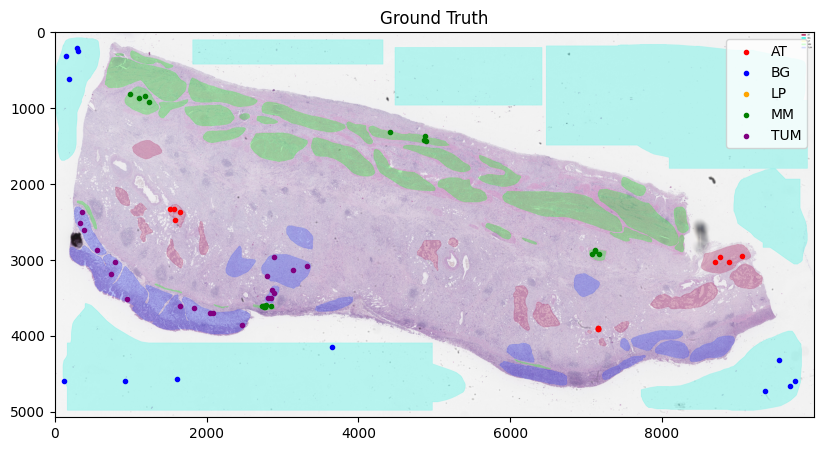

In [11]:
position = deepcopy(coords.cpu().numpy())
chose_file_name = img_path[0].split('/')[-1]
image = mpimg.imread(f'previews/{chose_file_name[:7]}.jpg')
plt.figure(figsize=(16,5))
psim_width_height = {'test_01':{'width':111552,'height':90473},
                     'test_02': {'width':91632,'height':72603},
                     'test_03': {'width':59760,'height':87721},
                     'test_04': {'width':105576,'height':83757},
                     'test_05': {'width':105576,'height':53560},
                     }
plt.imshow(image)
height,width,c = image.shape
ratio_height = psim_width_height[chose_file_name[:7]]['height'] //2 / height
ratio_width = psim_width_height[chose_file_name[:7]]['width'] //2  / width
category_labels = ['AT', 'BG', 'LP', 'MM', 'TUM']
points = position
points[:,0] = points[:,0] * (psim_width_height[chose_file_name[:7]]['width'] // 2)
points[:,1] = points[:,1] * (psim_width_height[chose_file_name[:7]]['height'] //2 )
points[:,1] = points[:,1] // ratio_height
points[:,0] = points[:,0] // ratio_height
# 定义颜色映射
# points = points.transpose(0,1)
# colors = ['orange', 'cyan', 'green', 'red', 'blue']
colors = ['red', 'blue', 'orange', 'green', 'purple']
for i in range(len(category_labels)):
    mask = y_true.detach().cpu().numpy() == i
    plt.scatter(points[mask, 0], points[mask, 1], marker='.', c=colors[i], label=category_labels[i])
plt.title("Ground Truth")
plt.legend()
plt.show()

In [12]:
from models.graph_hnet import knn_euclidean,knn
import networkx as nx
k=3
knn_ = knn_euclidean(k=k)
edge_index = knn_(coords.unsqueeze(0))
print(edge_index[0,0].shape)

torch.Size([64, 3])


In [13]:
adj_list = edge_index[0,0]

# 创建一个 64x64 的邻接矩阵
adj_matrix = np.zeros((64, 64), dtype=int)

# 遍历 adj_list，并填充 adj_matrix
for i in range(64):
    for j in range(k):
        adj_matrix[i, adj_list[i, j]] = 1
        adj_matrix[adj_list[i, j], i] = 1  # 如果是无向图
    adj_matrix[i,i] =0 
# print(tabulate(adj_matrix, tablefmt="grid"))

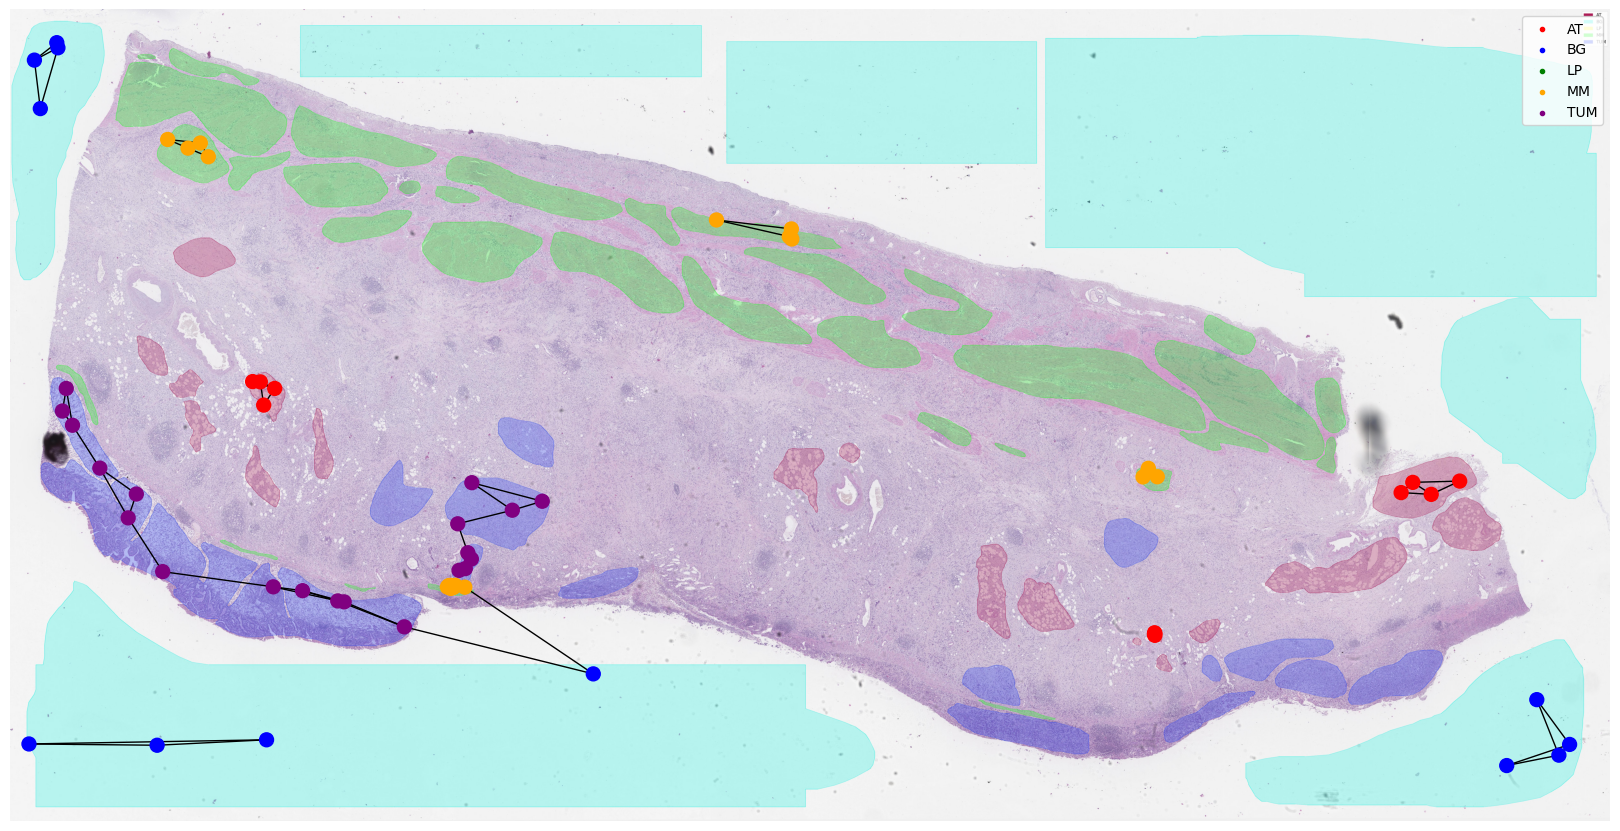

In [14]:
# pos_matrix = position[0].numpy().copy()
pos_matrix = points

# 创建图
G = nx.Graph()
colors = ['red', 'blue', 'green', 'orange', 'purple']
category_labels = ['AT', 'BG', 'LP', 'MM', 'TUM']
gt = y_true.detach().cpu().numpy()
# 添加节点
for i in range(64):
    G.add_node(i, pos=(pos_matrix[i,0], pos_matrix[i,1]), color=colors[gt[i]])

# 画图
pos = nx.get_node_attributes(G, 'pos')
node_colors = [G.nodes[node]['color'] for node in G.nodes()]


# 添加边
for i in range(64):
    for j in range(64):
        if adj_matrix[i,j] == 1:
            G.add_edge(i,j)

    # break

# 绘制图
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(16,10))
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=100)
for i in range(len(category_labels)):
    mask = y_true.detach().cpu().numpy() == i
    plt.scatter(points[mask, 0], points[mask, 1], marker='.', c=colors[i], label=category_labels[i])
plt.legend()
plt.imshow(image)
plt.show()